### Wire cutting as a method to improve performance of quantum circuits

Circuit-knitting is an umbrella term which encapsulates various methods of partitioning a circuit in multiple smaller subcircuits involving fewer gates and/or qubits. Each of the subcircuits can be executed independently and the final result is obtained via some classical postprocessing over the outcome of each subcircuit.

This notebook deals with a method called <b>wire cutting</b> where the circuit is partitioned along the wire [1,2]. Note that, partitioning is simple in classical circuits since the outcome at the point of partition can be determined deterministically, and is either 0 or 1. However, the state of the qubit at the point of the cut is, in general, a mixed state. Therefore, each subcircuit needs to be measured multiple times in different basis (usually a tomographically complete set of basis such as the Pauli basis [3,4]) and correspondingly prepared in its eigenstate. The Figure below (<i>courtesy: PhD Thesis, Ritajit Majumdar</i>) shows an example of wire cutting for a 4-qubit GHZ state into three subcircuits. Here $M_j$ denote a set of basis (usually Pauli X, Y and Z) and $P_i$ denote a set of eigenstates (usually $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|+i\rangle$).

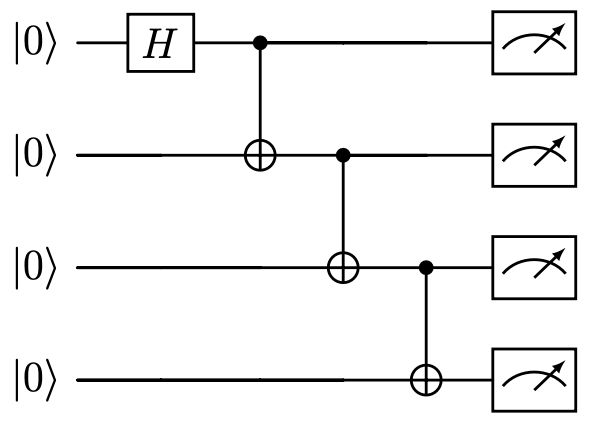
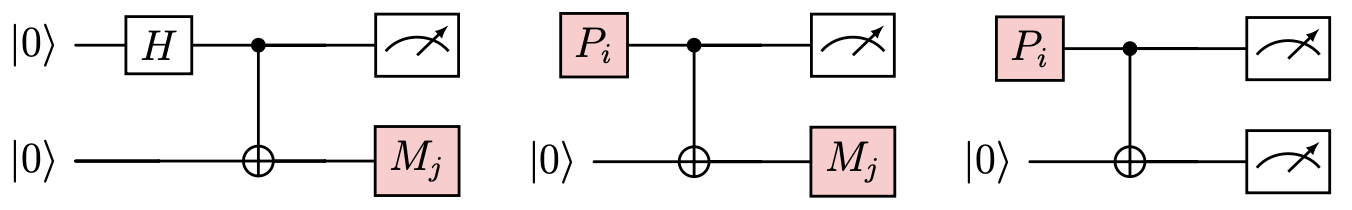

Since each subcircuit has fewer qubits and/or gates, they are expected to be less amenable to noise. This notebook shows an example where this method can be used to effectively suppress the noise in the system.

### Start

We shall take a **QAOA** [5] circuit as an example for this notebook. A QAOA is a variational algorithm where first a trial parameterized circuit, called **ansatz**, is prepared which is initialized, usually, with some random parameters. The circuit is then measured, and the expectation value of some observable is calculated. This entire process is called one *iteration*. This value is passed on to a classical optimizer, which predicts a new set of parameters such that the following iteration is expected to produce a better expectation value. This process is repeated till some convergence criteria is met.

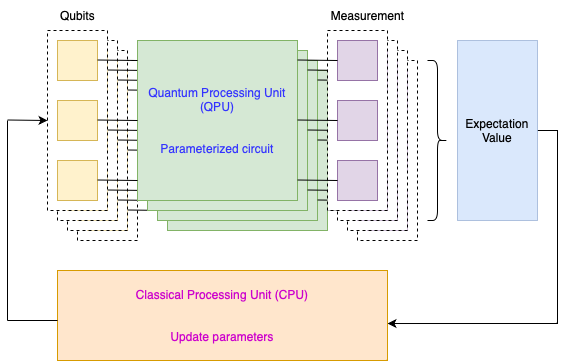

A QAOA circuit is characterized by two unitaries $U(H_P,\gamma)$ and $U(H_M,\beta)$, where $\gamma$ and $\beta$ are parameters. $H_P$ is the Hamltonian whose ground state is the solution of the problem at hand (e.g., vertex cover, max-cut etc.), and $H_M$ is some other Hamiltonian such that $[H_P,H_M] \neq 0$. A depth-p QAOA ansatz is mathematically expressed as:

<center>$|\gamma, \beta \rangle_p = U(H_M,\beta_p)U(H_P,\gamma_p) ... U(H_M,\beta_1)U(H_P,\gamma_1)|\psi_0 \rangle$</center>     

$|\psi_0 \rangle$ being some initial state, often an equal superposition state.

### Build

Here we show the function to build a QAOA circuit. Initially we build a template circuit without any specific parameter values. We also provide placeholders, called **CutWire**, to annotate the position of cuts.

In [90]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from numpy.random import default_rng
from numpy import pi
from typing import Optional

from circuit_knitting.cutting.instructions import CutWire

def build_qaoa_circuit(
    num_qubits: int,
    depth: int, # here the convention is depth=2*p,
    use_cut: bool = False,
    cut_qubit: Optional[int] = None,
    ):
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    if use_cut and cut_qubit is None:
        cut_qubit = num_qubits//2
        if cut_qubit%2 == 0:
            cut_qubit += 1

    if use_cut:
        assert cut_qubit%2 == 1, "cut_qubit should be odd"

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        for qubit in range(0, num_qubits - 1, 2):
            if use_cut and qubit == cut_qubit+1:
                if layer == 0:
                    circuit.rzz(gammas[layer], qubit, qubit + 1)
                    circuit.append(CutWire(),[qubit])
                else:
                    circuit.append(CutWire(),[qubit])
                    circuit.rzz(gammas[layer], qubit, qubit + 1)
                    circuit.append(CutWire(),[qubit])
            else:
                circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            if use_cut and qubit == cut_qubit+1:
                circuit.append(CutWire(),[qubit])
                circuit.rzz(gammas[layer], qubit, qubit + 1)
                #circuit.append(CutWire(),[qubit])
            else:
                circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    return circuit

def produce_qaoa_parameters(num_layers, seed=None):
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()

    params = []
    for idx in range(len(betas)):
        params.append(gammas[idx])
        params.append(betas[idx])
    return params

We shall start with a 6 qubit p = 1 QAOA circuit for simplicity. We shall show the scalability of this approach later on in the notebook.

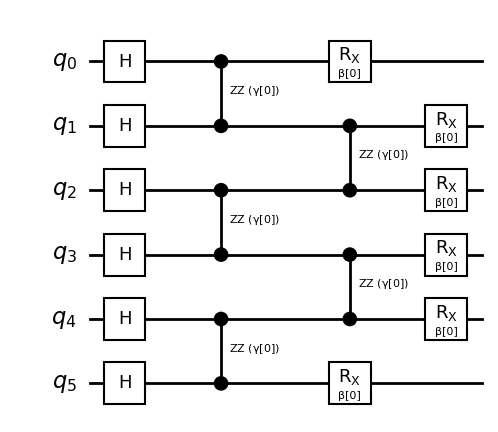

In [2]:
num_qubits = 6
p = 1
qaoa = build_qaoa_circuit(num_qubits,2*p)
qaoa.draw('mpl', style='bw', fold=-1)

Now we annotate the circuit for cutting by inserting proper **CutWire** to create two roughly equal cuts. We set *use_cut=True* in the function, and allow it to annotate after n/2 qubits, n being the number of qubits in the original circuit.

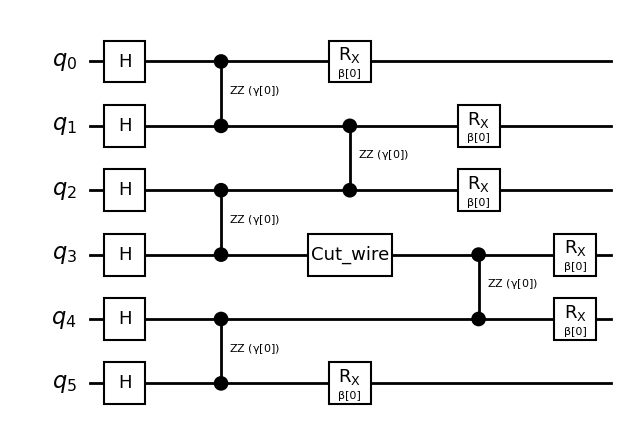

In [3]:
qaoa_cut = build_qaoa_circuit(num_qubits,2*p,use_cut=True,cut_qubit=3)
qaoa_cut.draw('mpl', style='bw', fold=-1)

### Optimize

Next we cut the circuit into two smaller subcircuits. For this example, we stick to only 2 subcircuits. For this, we use the <a href="https://qiskit-extensions.github.io/circuit-knitting-toolbox/index.html">Circuit Knitting Toolbox</a> from Qiskit Ecosystem.

Before running this notebook, it is necessary to install the Circuit Knitting Toolbox. This can be done simply by executing

<i>pip install circuit_knitting_toolbox</i>

#### Cut the circuit into smaller subcircuits

Cutting the wire at a point increases the qubit count by one. Apart from the original qubit, there is now an extra qubit as a placeholder to the circuit after cutting. The following image gives a representation:

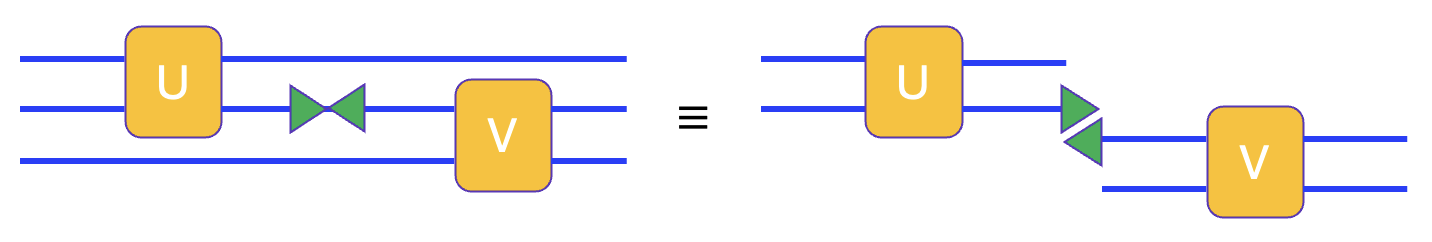

Circuit-knitting-toolbox uses the function *cut_wires* to account for the extra qubits arising due to cutting.

In [4]:
from circuit_knitting.cutting import cut_wires, expand_observables

qaoa_move = cut_wires(qaoa_cut)

#### Create and expand the observables

First we create the observable for the problem. Since we have considered a QAOA circuit, we shall use the observable corresponding to the Max-Cut problem: $\sum_{(i,j)\in E} Z_i Z_j$. Note that the lower the value of this observable, the better is the result. This allows us to compare the performance of this algorithm with and without circuit cutting, even without knowing the exact result.

Here, we first create the $Z_i Z_j$ observables for each edge.

In [5]:
from qiskit.quantum_info import PauliList

observable = PauliList(['I'*i + 'ZZ' + 'I'*(num_qubits-i-2) for i in range(num_qubits-1)])
observable

PauliList(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ'])

However, note that the number of qubits in the circuit has increased after inserting the virtual 2-qubit **Move** operations after cutting. Therefore, we expand the observables as well by inserting identitites to assert to the current circuit.

In [6]:
new_obs = expand_observables(observable, qaoa, qaoa_move)
new_obs

PauliList(['ZZIIIII', 'IZZIIII', 'IIZIZII', 'IIIIZZI', 'IIIIIZZ'])

Now we shall partition the circuit into two subcircuits

In [7]:
from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

partitioned_problem = partition_problem(circuit=qaoa_move, observables=new_obs)

Let us visualize the subcircuits

In [8]:
subcircuits = partitioned_problem.subcircuits

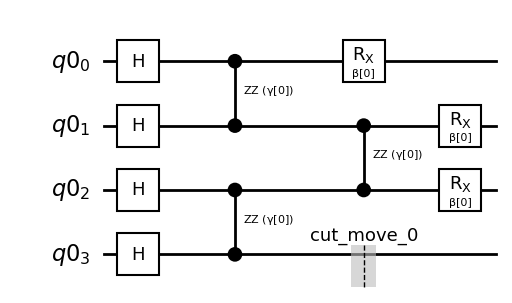

In [9]:
subcircuits[0].draw('mpl', style='bw', fold=-1)

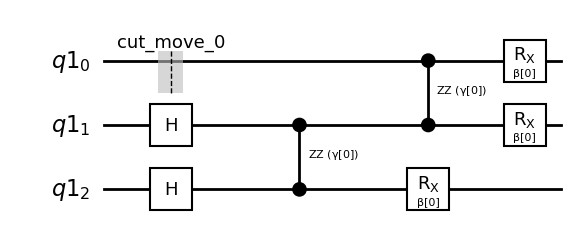

In [10]:
subcircuits[1].draw('mpl', style='bw', fold=-1)

The observables have been partitioned as well to fit the subcircuits

In [11]:
subobservables = partitioned_problem.subobservables
subobservables

{0: PauliList(['IIII', 'IIII', 'IZII', 'IZZI', 'IIZZ']),
 1: PauliList(['ZZI', 'IZZ', 'IIZ', 'III', 'III'])}

### Run and postprocess

Note that each subcircuit leads to a number of samples. The reconstruction takes into account the outcome of each of these samples. Each of these samples is termed a *subexperiment* in Circuit-knitting-toolbox.

In [12]:
import numpy as np

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

Let us see two examples where the cut qubits are measured in two different basis. First, it is measured in normal Z basis, and next it is measured in X basis.

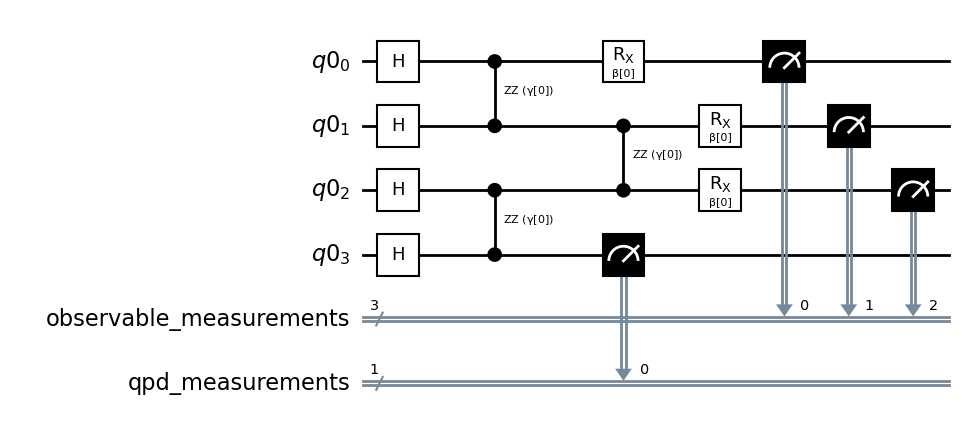

In [13]:
subexperiments[0][6].draw('mpl', style='bw', fold=-1)

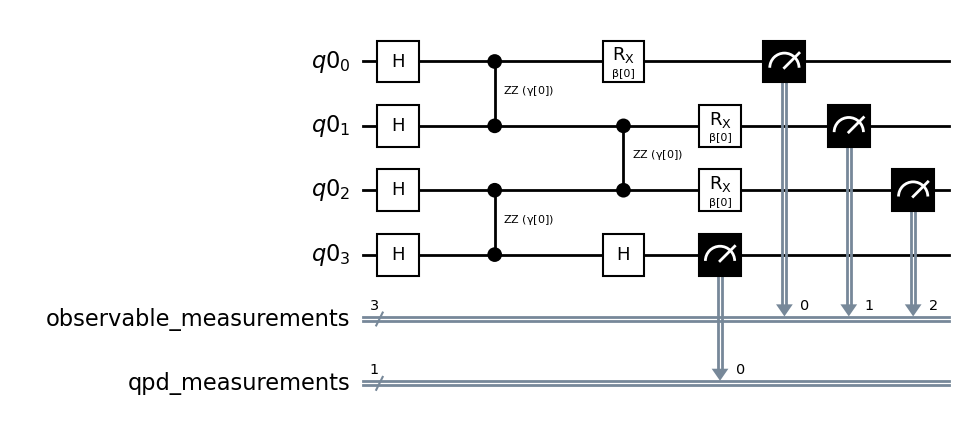

In [14]:
subexperiments[0][2].draw('mpl', style='bw', fold=-1)

#### Transpile each subexperiment

Currently we need to traspile our circuits before submitting them for execution. Therefore, we shall transpile each circuit in the subexperiments first.

In order to avoid running on queue, we shall use a FakeBackend for this smaller simulation. We shall show results from real backend later on in the notebook.

We shall select the noise model from a backend to insert to this Generic Backend

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit_aer.noise import NoiseModel

In [16]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_osaka')
simulator = service.get_backend('ibmq_qasm_simulator')

In [17]:
noise_model = NoiseModel.from_backend(backend)

In [18]:
options = Options()
options.execution.shots = 4000
options.transpilation.skip_transpilation = True
options.resilience_level = 0
options.simulator.noise_model = noise_model

Now we need to transpile each of the circuits in the subexperiments. For that we first create a pass manager, and then use it to transpile each of the circuits.

In [19]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(2, basis_gates=['x','sx','ecr','rz','id'])

In [20]:
subexperiments_trans = {}

for key, subckt in subexperiments.items():
    subexperiments_trans[key] = pm.run(subckt)

In [21]:
subexperiments_trans[0][0].draw(fold=-1)

global phase: π/2
                           ┌─────────┐   ┌────┐  ┌──────┐   ┌───┐    ┌──────────┐                ┌──────┐   ┌───┐    ┌─────────┐   ┌────┐   ┌──────────────┐┌────┐┌──────────┐        ┌─┐                                                                                 
                     q0_0: ┤ Rz(π/2) ├───┤ √X ├──┤0     ├───┤ X ├────┤ Rz(-π/2) ├────────────────┤0     ├───┤ X ├────┤ Rz(π/2) ├───┤ √X ├───┤ Rz(β[0] + π) ├┤ √X ├┤ Rz(5π/2) ├────────┤M├─────────────────────────────────────────────────────────────────────────────────
                           └──┬────┬─┘┌──┴────┴─┐│  Ecr │┌──┴───┴───┐└┬────────┬┘┌────┐┌────────┐│  Ecr │┌──┴───┴───┐└─┬──────┬┘   ├───┬┘   └─┬──────────┬─┘└────┘└──────────┘┌──────┐└╥┘   ┌───┐   ┌─────────┐     ┌────┐     ┌──────────────┐   ┌────┐   ┌──────────┐┌─┐
                     q0_1: ───┤ √X ├──┤ Rz(π/2) ├┤1     ├┤ Rz(γ[0]) ├─┤ Rz(-π) ├─┤ √X ├┤ Rz(-π) ├┤1     ├┤ Rz(-π/2) ├──┤0     ├────┤ X ├──────┤ Rz(-π/2) ├────────────────────┤0     ├─╫────┤ X ├───┤ Rz(π/2) ├─────┤ √X ├─────┤ Rz(β[0] + π) ├───┤ √X ├───┤ Rz(5π/2) ├┤M├
                           ┌──┴────┴─┐└──┬────┬─┘├──────┤└──┬───┬───┘┌┴────────┴┐└────┘└────────┘├──────┤└──┬────┬──┘  │  Ecr │ ┌──┴───┴───┐  └┬────────┬┘  ┌────┐ ┌────────┐ │  Ecr │ ║ ┌──┴───┴──┐└──┬────┬─┘┌────┴────┴────┐└────┬────┬────┘┌──┴────┴──┐└───┬─┬────┘└╥┘
                     q0_2: ┤ Rz(π/2) ├───┤ √X ├──┤0     ├───┤ X ├────┤ Rz(-π/2) ├────────────────┤0     ├───┤ √X ├─────┤1     ├─┤ Rz(γ[0]) ├───┤ Rz(-π) ├───┤ √X ├─┤ Rz(-π) ├─┤1     ├─╫─┤ Rz(π/2) ├───┤ √X ├──┤ Rz(β[0] + π) ├─────┤ √X ├─────┤ Rz(5π/2) ├────┤M├──────╫─
                           └──┬────┬─┘┌──┴────┴─┐│  Ecr │┌──┴───┴───┐└┬────────┬┘┌────┐┌────────┐│  Ecr │   └────┘     └──────┘ └──────────┘   └────────┘   └────┘ └────────┘ └──────┘ ║ └─────────┘   └────┘  └──────────────┘     └────┘     └──────────┘    └╥┘      ║ 
                     q0_3: ───┤ √X ├──┤ Rz(π/2) ├┤1     ├┤ Rz(γ[0]) ├─┤ Rz(-π) ├─┤ √X ├┤ Rz(-π) ├┤1     ├──────────────────────────────────────────────────────────────────────────────╫────────────────────────────────────────────────────────────────────────╫───────╫─
                              └────┘  └─────────┘└──────┘└──────────┘ └────────┘ └────┘└────────┘└──────┘                                                                              ║                                                                        ║       ║ 
observable_measurements: 3/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩════════════════════════════════════════════════════════════════════════╩═══════╩═
                                                                                                                                                                                       0                                                                        2       1

#### Run the optimization

Recall that we aim to find the expectation value of the observable $\sum_{(i,j) \in edge}Z_i Z_j$. This expectation value is proportional to the Max-Cut value of the QAOA upto some constant terms [5]. The lower is the value, the better it is.

We initialize the initial set of parameters to some random value.

Note that due to the iterative method of QAOA, the run and postprocess steps are shown together. For each step, the circuit is executed, and the postprocessing step (i) calculates the expectation value for the observable, and in case of cutting (ii) merges the outcomes of different subcircuits.

In [22]:
init_params = produce_qaoa_parameters(p, seed=0)

Note that for each layer of QAOA there are two parameters. Therefore, each cut subcircuit also has two parameters. This makes the parameter assignment simpler. However, for more general problems, it is necessary to keep track of which parameter goes to which subcircuit, so that the assignment is proper.

In [23]:
def calculate_cut_expval(params: list, subexperiments: dict, coefficients: list, subobservables: dict, sampler) -> float:
    # assign parameters
    circuits = {}
    for key, ckt_list in subexperiments.items():
        circuits[key] = []
        for ckt in ckt_list:
            circuits[key].append(ckt.assign_parameters(params))

    # execute the circuits
    results = {
        label: sampler.run(subexp).result()
        for label, subexp in circuits.items()
    }

    # reconstruct and calculate expectation values
    reconstructed_expvals = reconstruct_expectation_values(
        results,
        coefficients,
        subobservables,
    )

    # return the sum of the expectation values
    return sum(reconstructed_expvals)

Often the optimization may run for hundreds of steps. For this example, we prematuredly stop the optimization after 5 steps

In [24]:
sampler = Sampler(backend=simulator, options=options)

In [25]:
from scipy.optimize import minimize

res = minimize(
    calculate_cut_expval, init_params, args=(subexperiments_trans, coefficients, subobservables, sampler), method="cobyla", options={'maxiter':5}
)

/var/folders/29/5g097jln3fx21kr9g9vfc4540000gn/T/ipykernel_15891/3246579515.py:11: DeprecationWarning: Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.
  label: sampler.run(subexp).result()


In [26]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.9124577500000002
       x: [-4.465e-01  8.606e-01]
    nfev: 5
   maxcv: 0.0

### Cross verify

Let us now run the same QAOA without circuit cutting, keeping other parameters and variables same.

In [27]:
from qiskit.quantum_info import SparsePauliOp

In [28]:
trans_qaoa = pm.run(qaoa)

In [29]:
observable = SparsePauliOp(observable)
observable

SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

#### Execute

In [30]:
def calculate_uncut_expval(params: list, circ: QuantumCircuit, observsble: SparsePauliOp, estimator) -> float:
    # assign parameters
    circuit = circ.assign_parameters(params)
    
    # execute
    expval = estimator.run(circuit, observable).result().values[0]

    return expval

In [31]:
estimator = Estimator(backend=simulator, options=options)

In [32]:
res = minimize(
    calculate_uncut_expval, init_params, args=(trans_qaoa, observable, estimator), method="cobyla", options={'maxiter':5}
)

/var/folders/29/5g097jln3fx21kr9g9vfc4540000gn/T/ipykernel_15891/918225121.py:6: DeprecationWarning: Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.
  expval = estimator.run(circuit, observable).result().values[0]


In [33]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.6695
       x: [-4.465e-01  8.606e-01]
    nfev: 5
   maxcv: 0.0

### Inference

Recall that the observable was selected from the Max-Cut problem, and lower the value of the objective function, the better it is. We observe that after 5 steps of iteration, the cut QAOA reached an objective function which is lower than that of the uncut QAOA. This shows that cutting itself can suppress the effect of noise by lowering the number of qubits and/or gates.

Note that it is possible to use other error suppression and mitigation methods together with circuit cutting to further improve the performance. Moreover, in this notebook, we computed both the subcircuits on the same hardware. In [6,7], the authors shows a method to distribute the subcircuits on different hardware using noise information in order to maximize the noise suppression, and parallelize the process.

### Scalability

Previously, we showed the results for a 6-qubit QAOA circuit. Next, we show that this method is scalable, and repeat the process for a 50-qubit QAOA circuit.

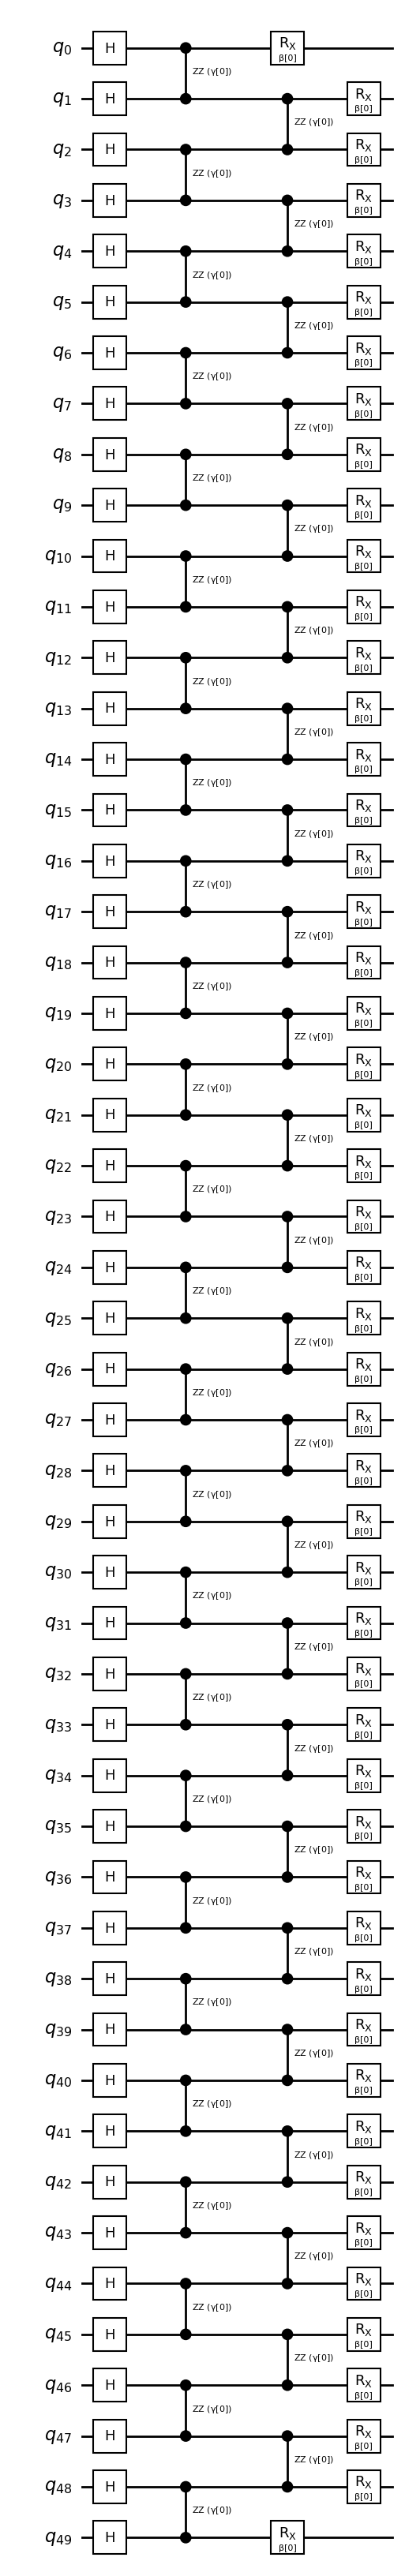

In [34]:
num_qubits = 50
p = 1
qaoa = build_qaoa_circuit(num_qubits,2*p)
qaoa.draw('mpl', style='bw', fold=-1)

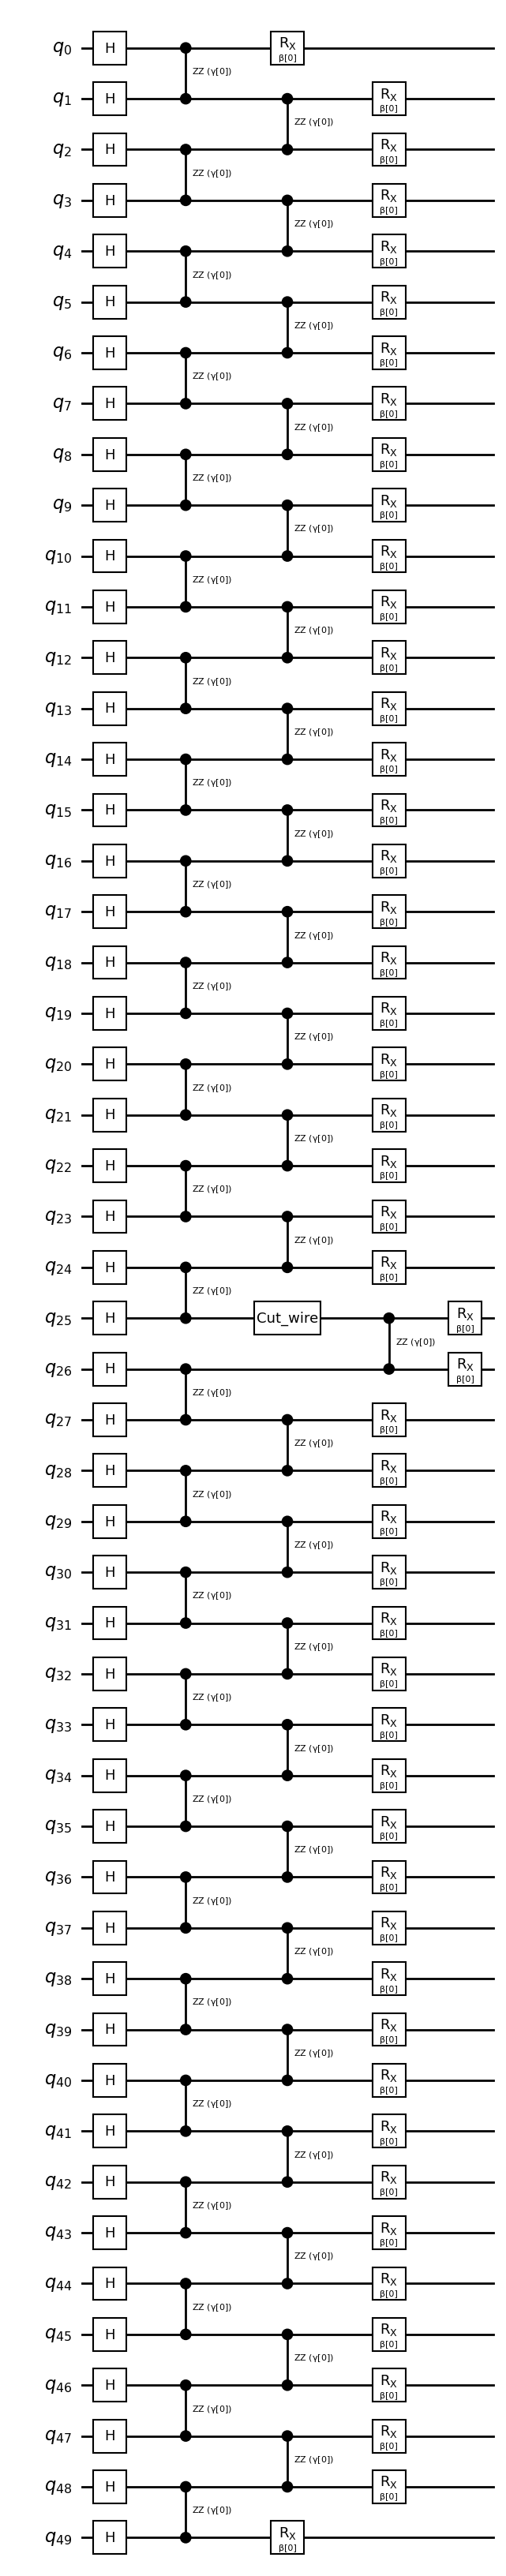

In [35]:
qaoa_cut = build_qaoa_circuit(num_qubits,2*p,use_cut=True)
qaoa_cut.draw('mpl', style='bw', fold=-1)

In [38]:
qaoa_move = cut_wires(qaoa_cut)

In [39]:
observable = PauliList(['I'*i + 'ZZ' + 'I'*(num_qubits-i-2) for i in range(num_qubits-1)])
new_obs = expand_observables(observable, qaoa, qaoa_move)

In [7]:
from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

partitioned_problem = partition_problem(circuit=qaoa_move, observables=new_obs)

In [8]:
subcircuits = partitioned_problem.subcircuits

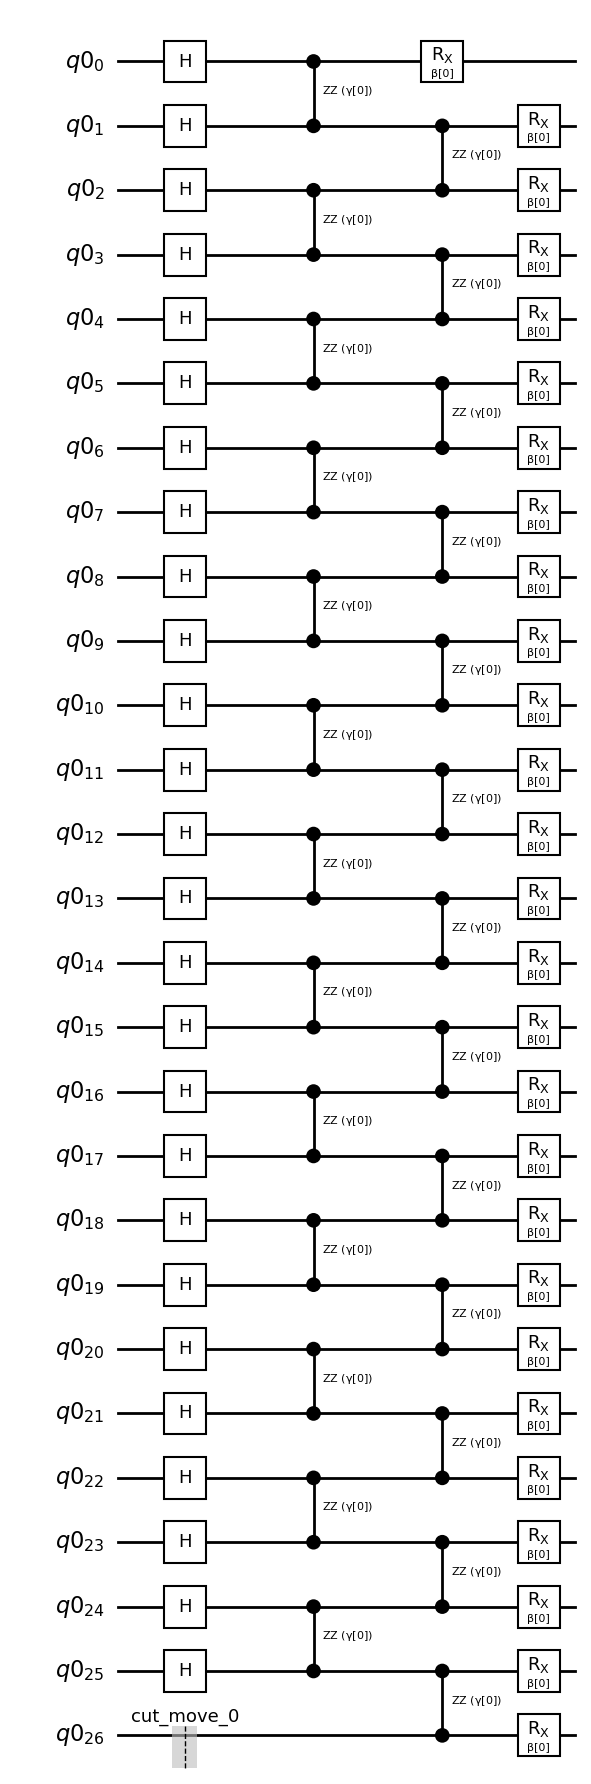

In [9]:
subcircuits[0].draw('mpl', style='bw', fold=-1)

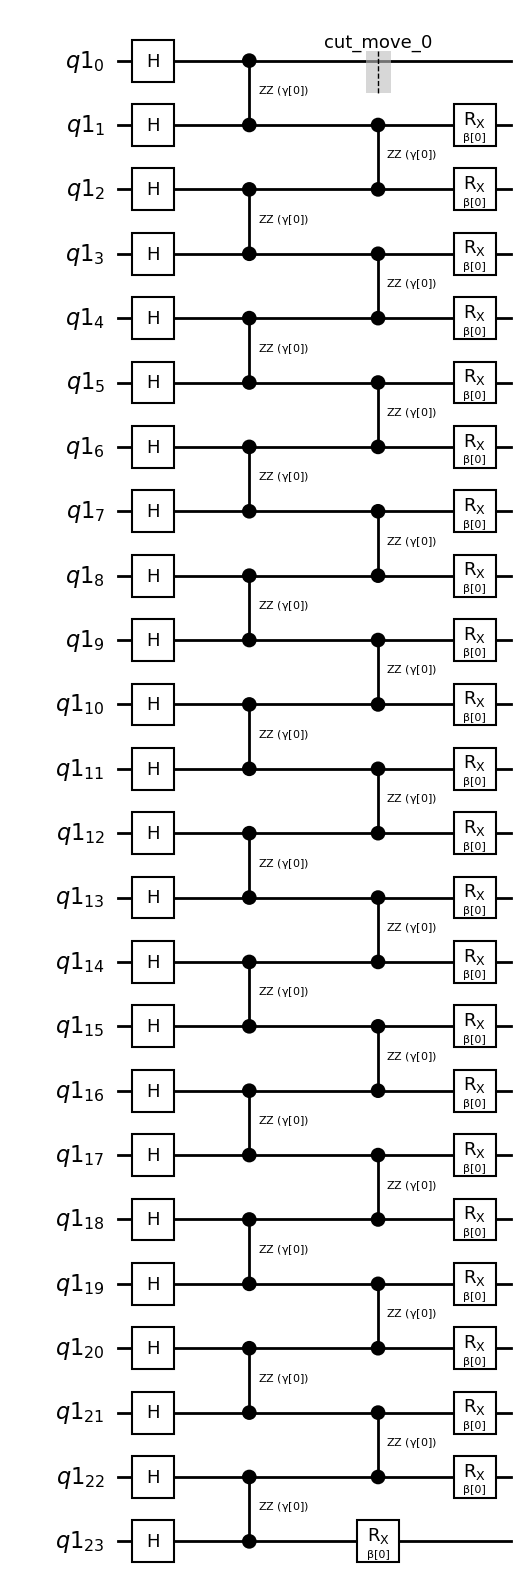

In [10]:
subcircuits[1].draw('mpl', style='bw', fold=-1)

In [11]:
subobservables = partitioned_problem.subobservables
subobservables

{0: PauliList(['IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'ZIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIIIIIIIIII',
            'IZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIIIIIIII',
            'IIIZZIIIIIIIIIIIIIIIII

In [12]:
import numpy as np

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

In [42]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(2, backend)

In [16]:
subexperiments_trans = {}

for key, subckt in subexperiments.items():
    subexperiments_trans[key] = pm.run(subckt)

In [18]:
options = Options()
options.execution.shots = 4000
options.transpilation.skip_transpilation = True
options.resilience_level = 0

In [19]:
def calculate_cut_expval(params: list, subexperiments: dict, coefficients: list, subobservables: dict, sampler) -> float:
    # assign parameters
    circuits = {}
    for key, ckt_list in subexperiments.items():
        circuits[key] = []
        for ckt in ckt_list:
            circuits[key].append(ckt.assign_parameters(params))

    # execute the circuits
    results = {
        label: sampler.run(subexp).result()
        for label, subexp in circuits.items()
    }

    # reconstruct and calculate expectation values
    reconstructed_expvals = reconstruct_expectation_values(
        results,
        coefficients,
        subobservables,
    )

    # return the sum of the expectation values
    return sum(reconstructed_expvals)

In [20]:
from scipy.optimize import minimize

with Session(backend=backend):
    sampler = Sampler(options=options)
    res = minimize(
        calculate_cut_expval, init_params, args=(subexperiments_trans, coefficients, subobservables, sampler), method="cobyla", options={'maxiter':10}
    )

In [21]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -18.93506837499775
       x: [-6.910e-01  8.084e-01]
    nfev: 10
   maxcv: 0.0

In order to run in real hardware, the observables need to be mapped to the transpiled circuit layout

In [43]:
trans_qaoa = pm.run(qaoa)

In [44]:
layout = trans_qaoa.layout.final_index_layout()
layout

[103,
 102,
 101,
 100,
 110,
 118,
 117,
 116,
 115,
 114,
 109,
 96,
 97,
 98,
 91,
 79,
 80,
 81,
 72,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 55,
 49,
 50,
 51,
 36,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 34,
 43,
 42,
 41,
 53,
 60,
 59,
 58,
 57,
 56]

In [45]:
observable = SparsePauliOp(observable)
observable = observable.apply_layout(layout, num_qubits=backend.num_qubits)

In [27]:
def calculate_uncut_expval(params: list, circ: QuantumCircuit, observsble: SparsePauliOp, estimator) -> float:
    # assign parameters
    circuit = circ.assign_parameters(params)
    
    # execute
    expval = estimator.run(circuit, observable).result().values[0]

    return expval

In [28]:
with Session(backend=backend):
    estimator = Estimator(options=options)
    res = minimize(
        calculate_uncut_expval, init_params, args=(trans_qaoa, observable, estimator), method="cobyla", options={'maxiter':10}
    )

In [29]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -17.819000000000003
       x: [-7.419e-01  8.364e-01]
    nfev: 10
   maxcv: 0.0

### Word of caution

The number of circuits to be executed increases with the number of cuts. Therefore, while many cuts can produce small subcircuits, thus further improving the performance, it also leads to a significantly high number of circuit executions, which may not be practical for most cases. Below, we show an example of the number of subcircuits corresponding to the number of cuts for a 50-qubit circuit.

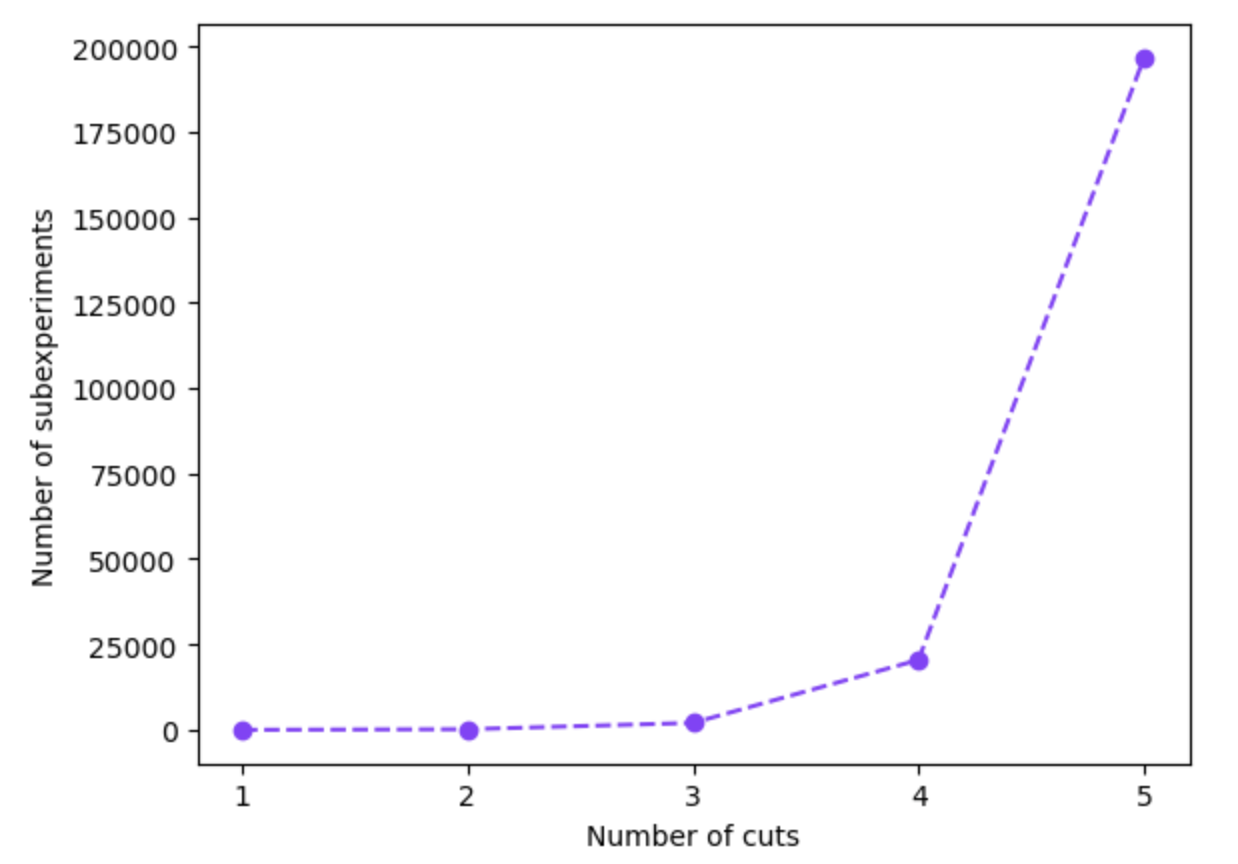

We note that even for 5 cuts the number of subexperiments is around 200k. Therefore, circuit cutting should be used only when the number of cuts is small.

### One example of cut-friendly and cut-unfriendly circuits each

#### Cut-friendly circuit

As noted earlier, a circuit is cut-friendly when the circuit can be partitioned into smaller disjoint subcircuits with a small number of cuts. Any hardware-efficient circuit, i.e., a circuit which requires little to no SWAP gates when mapped to the hardware coupling map, is, in general, cut-friendly. Below, we show an example of an excitation preserving ansatz, which is used in Quantum Chemistry. Note that such a circuit can be partitioned into two subcircuits with a single cut irrespective of the number of qubits.

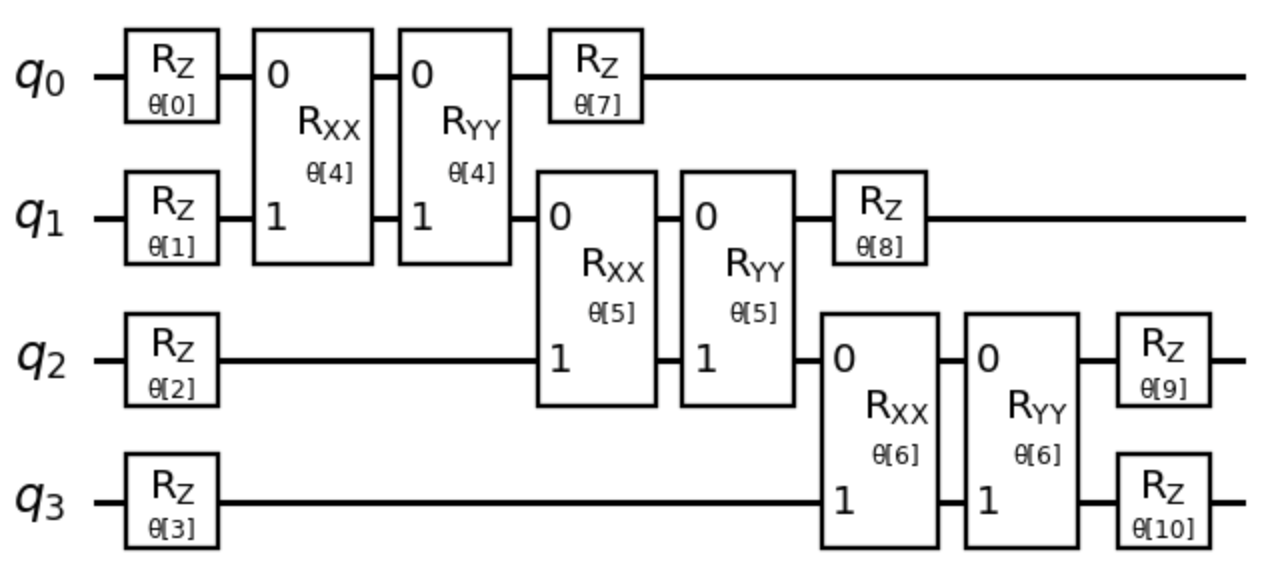

#### Cut-unfriendly circuit

A circuit is cut-unfriendly if, in general, the number of cuts required to form disjoint partitions grow significantly with the depth of the number of qubits. Recall that with each cut an extra qubit is required. So with the number of cuts, the effective number of qubits also increase. Below we show an example of a 3-qubit Grover circuit with a possible cutting instance.

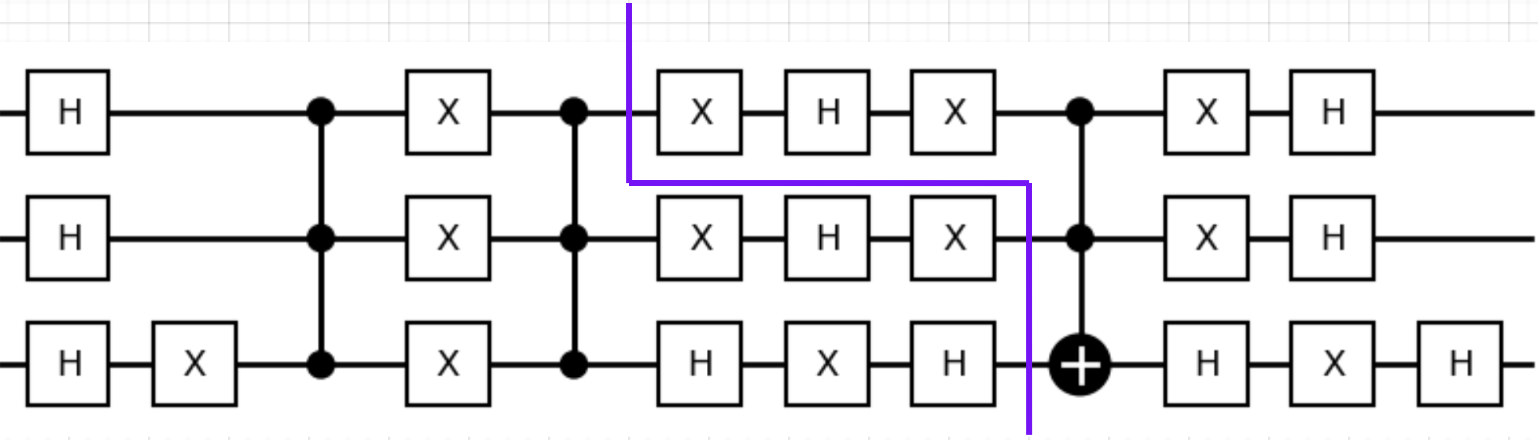

We note that three cuts are required, and the cut is more vertical than horizontal. This means, that the number of cuts is expected to scale linearly with the number of qubits, which is not amenable for cutting.

<b>References</b>

<ol>
  <li>Peng, T., Harrow, A. W., Ozols, M., & Wu, X. (2020). Simulating large quantum circuits on a small quantum computer. Physical review letters, 125(15), 150504.</li>
  <li>Tang, W., Tomesh, T., Suchara, M., Larson, J., & Martonosi, M. (2021, April). Cutqc: using small quantum computers for large quantum circuit evaluations. In Proceedings of the 26th ACM International conference on architectural support for programming languages and operating systems (pp. 473-486).</li>
  <li>Perlin, M. A., Saleem, Z. H., Suchara, M., & Osborn, J. C. (2021). Quantum circuit cutting with maximum-likelihood tomography. npj Quantum Information, 7(1), 64.</li>
  <li>Majumdar, R., & Wood, C. J. (2022). Error mitigated quantum circuit cutting. arXiv preprint arXiv:2211.13431.</li>
  <li>Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.</li>
  <li>Khare, T., Majumdar, R., Sangle, R., Ray, A., Seshadri, P. V., & Simmhan, Y. (2023). Parallelizing Quantum-Classical Workloads: Profiling the Impact of Splitting Techniques. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 990-1000). IEEE.</li>
  <li>Bhoumik, D., Majumdar, R., Saha, A., & Sur-Kolay, S. (2023). Distributed Scheduling of Quantum Circuits with Noise and Time Optimization. arXiv preprint arXiv:2309.06005.</li>
</ol>

In [32]:
from qiskit import __version__

__version__

'1.0.1'